In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2

# Implementa una version de K-medias usando esta definicion de mediana en lugar del centroide. 
Evalua su desempeno para recolorear una imagen a color: para una imagen a color, se toma como observaciones el conjunto de valores RGB de los pixeles, se aplica la nueva version de K-medias y al final se cambia el color de cada pixel por la mediana del cluster al cual fue asignado. Experimenta con K=2,3,5,10. Vas a ver que el punto de arranque es de gran importancia.

In [23]:
def median(data, tol=1e-5, N=100):
    theta = np.mean(data)
    for _ in range(N):
        dist = np.linalg.norm(data-theta, axis=1)
        dist[dist==0] = 1e-10
        weights = 1 / dist
        new_theta = np.average(data, axis=0, weights=weights)
        if np.linalg.norm(new_theta - theta) < tol:
            break
        theta = new_theta
    return theta

def recolor(img, K=2):
    pxs = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=K, random_state=0).fit(pxs)

    new_centers = []
    for k in range(K):
        clusters = pxs[kmeans.labels_==k]
        if len(clusters)>0:
            med = median(clusters)
            new_centers.append(med)
        else:
            new_centers.append(np.zeros(3))
    new_centers = np.array(new_centers, dtype=np.uint8)
    recolored = new_centers[kmeans.labels_].reshape(img.shape)
    return recolored


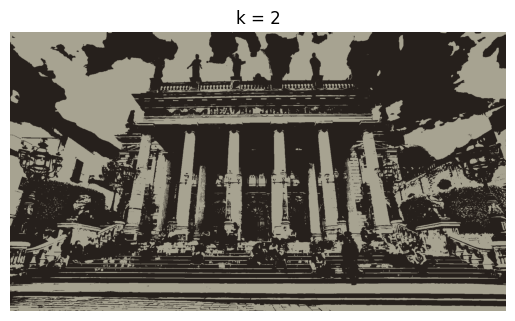

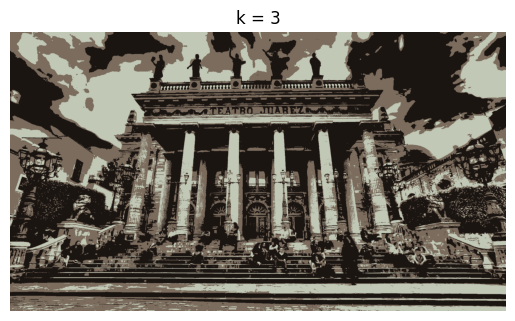

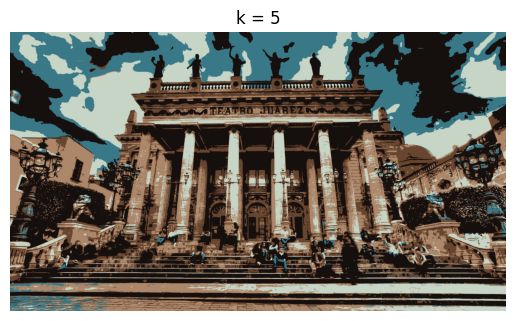

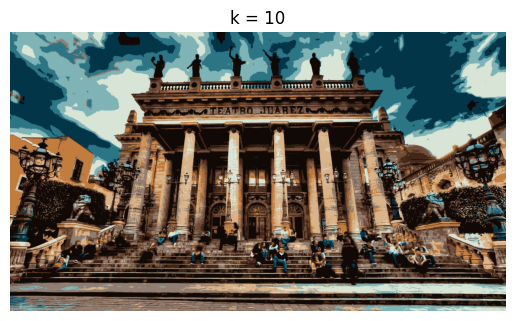

In [5]:
img = cv2.imread('teatro.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for K in [2,3,5,10]:
    new_img = recolor(img, K=K)
    cv2.imwrite(f'recolored_k{K}.jpg', cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(f'k = {K}')
    plt.show()

# Implementa el algoritmo EM para encontrar grupos en un conjunto de datos en el espacio ${x_i}$ con una mezcla de K distribuciones Gausianas y aplicalo al problema anterior de las imagenes.

In [24]:
def gauss(X, mu, cov):
    n, d = X.shape
    diff = X - mu
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    norm_const = 1.0 / (np.sqrt((2 * np.pi) ** d * np.linalg.det(cov)))
    return norm_const * np.exp(exponent)

def em(X, K, tol=1e-4, N=100):
    n, d = X.shape

    idx = np.random.choice(n, K, replace=False)
    mu = X[idx]
    cov = np.array([np.cov(X.T) + 1e-6 * np.eye(d) for _ in range(K)])
    pi = np.ones(K) / K
    
    log_likelihoods = []
    for it in range(N):
        # Paso E
        r = np.zeros((n, K))
        for k in range(K):
            r[:, k] = pi[k] * gauss(X, mu[k], cov[k])
        r /= r.sum(axis=1, keepdims=True)

        # Paso M
        N_k = r.sum(axis=0)
        pi = N_k / n
        mu = (r.T @ X) / N_k[:, np.newaxis]
        cov = []
        for k in range(K):
            diff = X - mu[k]
            cov_k = (r[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
            cov.append(cov_k + 1e-6 * np.eye(d))
        cov = np.array(cov)

        # Log likelihood
        densidades = np.zeros((n, K))
        for k in range(K):
            densidades[:, k] = pi[k] * gauss(X, mu[k], cov[k])
        ll = np.sum(np.log(np.sum(densidades, axis=1) + 1e-10))
        log_likelihoods.append(ll)

        # Convergencia
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    
    return mu, cov, pi, log_likelihoods, r


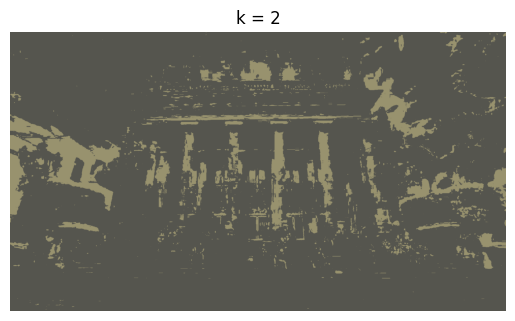

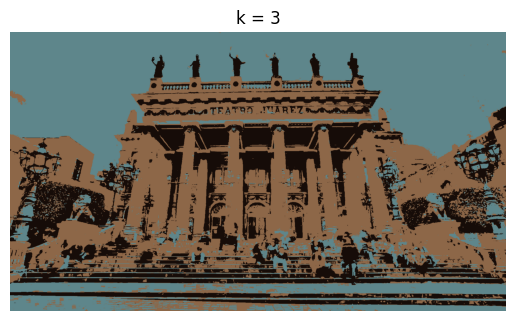

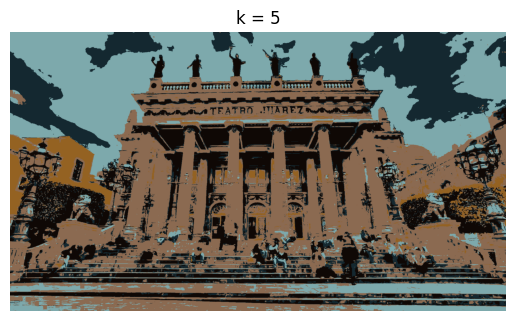

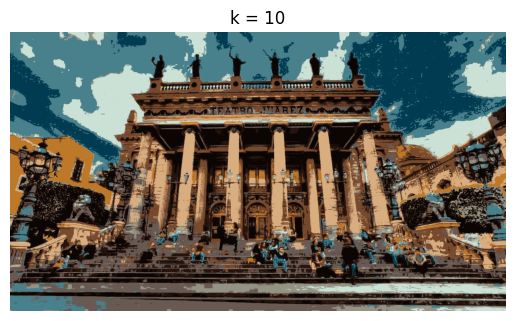

In [26]:
img = cv2.imread('teatro.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for K in [2,3,5,10]:
    mu, cov, pi, log_likelihoods, r = em(img.reshape((-1, 3)), K=K)

    labels = np.argmax(r, axis=1)
    new_colors = mu[labels]
    new_img = new_colors.reshape(img.shape)

    plt.imshow(new_img.astype(np.uint8))
    plt.axis('off')
    plt.title(f'k = {K}')
    plt.show()



# El archivo seguro_data.csv contiene datos historicos de clientes de una aseguradora.
Da una descripcion general de los datos apoyandote en algunas graficas
informativas.
Ajusta algunos modelos predictivos (Regresion Logistica, Arboles, SVM,  ́
etc.) para la variable y. Discute su ajuste e interpretabilidad (a partir
del modelo elegido). Utiliza visualizaciones si es posible.

De vez en cuando, se tiene interes en construir modelos predictivos justos (fair) respecto a variables sensibles (en este caso, la variable sensible es el sexo de la persona).

Usando las definiciones 1 a 4 de fairness de la seccion 4, evalua la equidad de algunos modelos basados en Regresion Logistica y Arboles.  ́

## Exploracion

Al explorar los datos se encuentra unicamente un dato con nan (el cual se elimina del dataset); decide eliminarse tambien a las columnas de ingresos y puntaje de riesgo no escalados.

In [28]:
df = pd.read_csv('../../datos/seguro_datos.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.dropna()
df = df.rename(columns={'x1': 'ingreso', 'x1_s': 'ingreso_esc', 'x2': 'sexo', 'x3': 'riesgo', 'x3_s': 'riesgo_esc', 'x4': 'civil', 'y': 'siniestro'})
df = df.drop(columns=['ingreso', 'riesgo'])

Se grafican los histogramas de cada variable.
- Se observa que la mayoria de lo clientes de la aseguradora se concentran hacia los ingresos mas bajos, con un pico muy prominente alrededor del 0
- Se observa una proporcion ligeramente mayor de un genero sobre el otro
- Por su parte, la distribucion de clientes por puntaje de riesgo parece aproximadamente uniforme, con el unico patron observable es el de una menor proporcion de clientes con los puntajes mas bajos y mas altos
- En el caso del estado civil, alrededor de las 2/3 partes de los asegurados estan casados o en union libre
- Finalmente, los clientes que generaron siniestro son ligeramente menos que los que no

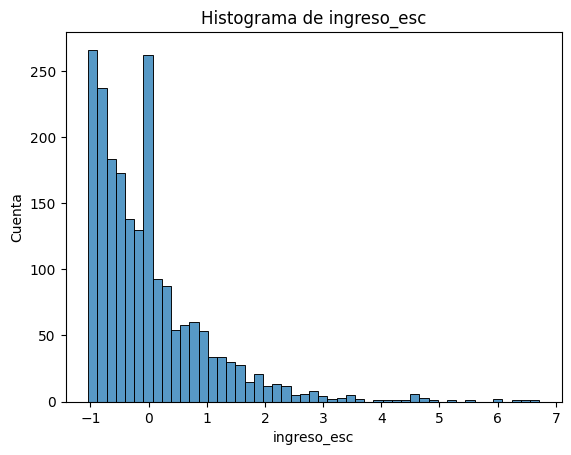

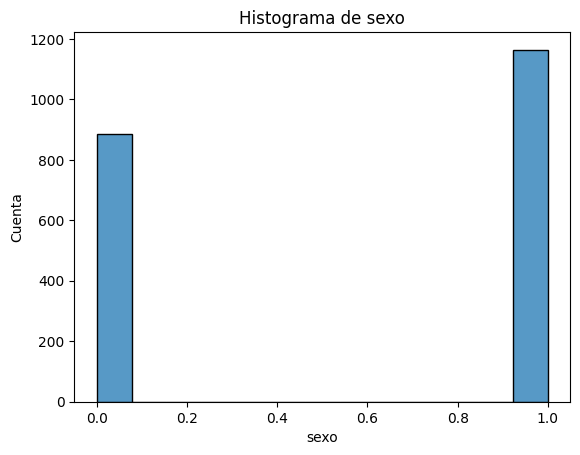

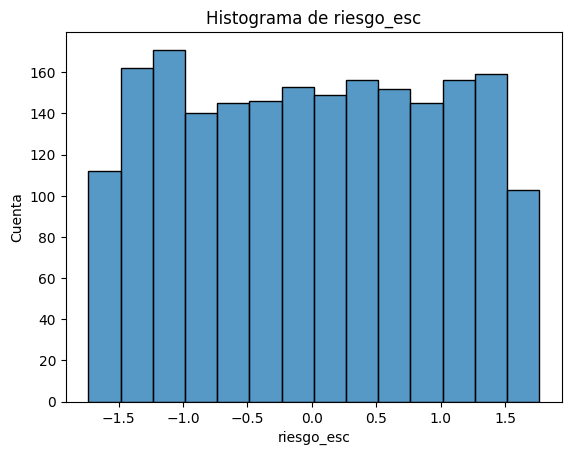

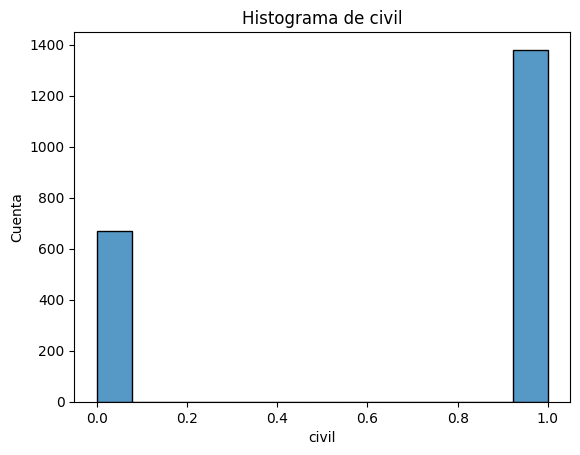

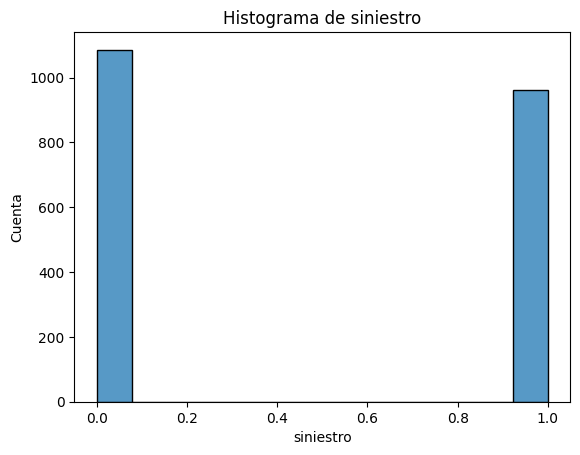

In [16]:
for col in df.columns:
    sns.histplot(df[col], label=col)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Cuenta')
    plt.show()

Se grafican las curvas de densidad separadas en aquellos que generaron un siniestro y los que no. Al observarlas se obtienen las siguientes conclusiones:
- Los clientes que generan siniestro son en su mayoria los de menores ingresos, mientras que los que no lo generan se concentran en los ingresos medios-bajos
- Hay una proporcion ligeramente mayor de hombres que no generan siniestro respecto a los que si, con el caso opuesto (de manera muy sutil) entre las mujeres
- La proporcion de personas que generan siniestro alcanza su pico entre las personas con mayor puntaje de riesgo, con el caso opuesto para las personas con menor puntaje
- La proporcion de personas que generaron siniestro contra los que no es muy similar sin importar el estado civil del asegurado

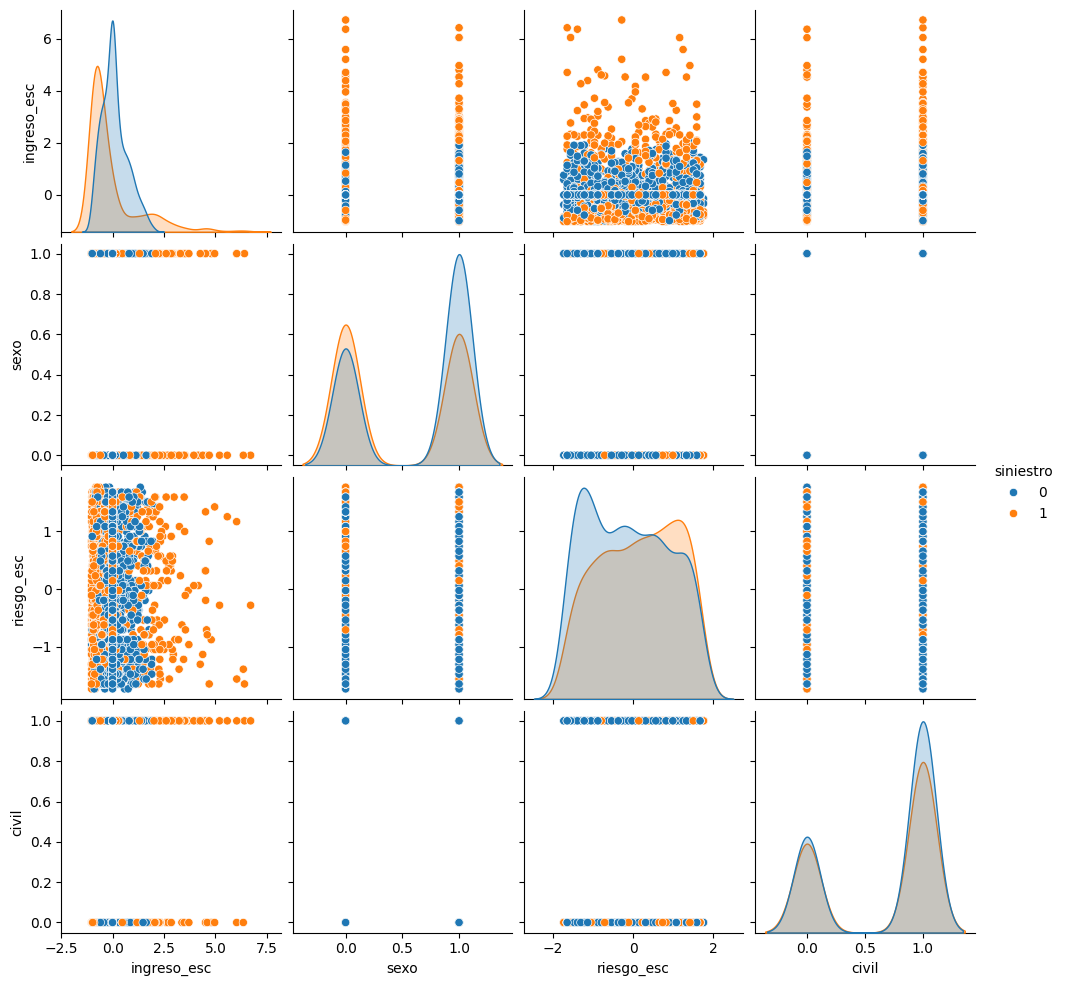

In [5]:
sns.pairplot(df, hue='siniestro')

Al graficar la proporcion de clientes que generaron siniestro segun su estado civil, se confirma que son aproximadamente iguales, alrededor de la mitad en ambos casos.

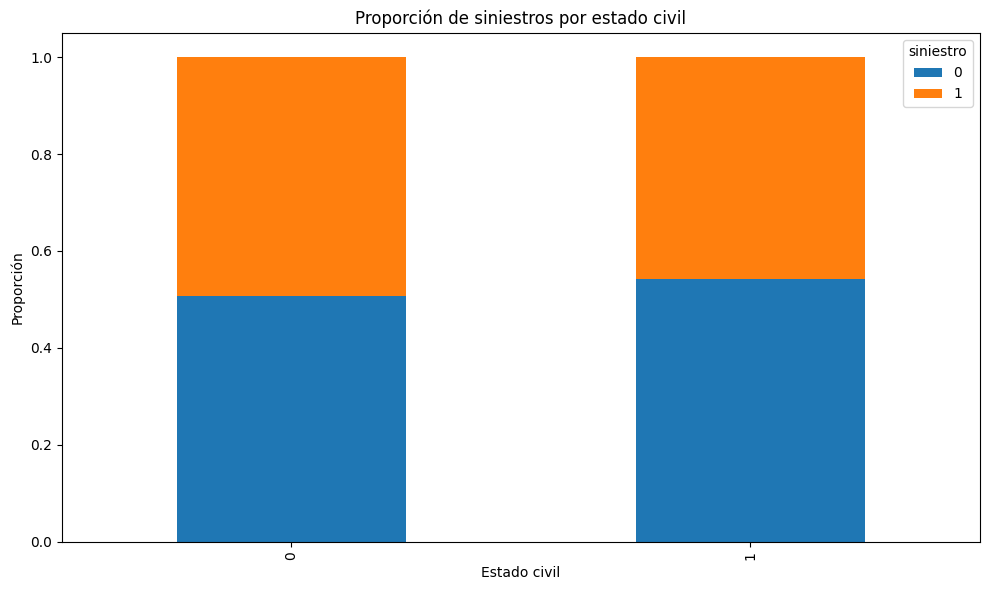

In [17]:
count = df.groupby(['civil', 'siniestro']).size().unstack(fill_value=0)
ratio = count.div(count.sum(axis=1), axis=0)
ratio.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proporción de siniestros por estado civil')
plt.xlabel('Estado civil')
plt.ylabel('Proporción')
plt.tight_layout()

## Clasificadores

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


### Preparacion de datos

In [112]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['siniestro'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Regresion logistica

In [31]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train_scaled, y_train)

y_pred_lr = clf_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.58      0.92      0.72       212
           1       0.78      0.29      0.43       198

    accuracy                           0.62       410
   macro avg       0.68      0.61      0.57       410
weighted avg       0.68      0.62      0.58       410



/home/juancho/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Arbol de decision
Al visualizar el arbol entrenado, se observo que podia podarse a una profundidad maxima de 2 sin grandes perjuicios a su rendimiento.

In [113]:
from sklearn.tree import plot_tree
clf_tree = DecisionTreeClassifier(max_depth=2)
clf_tree.fit(X_train, y_train)

y_pred_tree = clf_tree.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79       212
           1       0.83      0.64      0.72       198

    accuracy                           0.76       410
   macro avg       0.77      0.76      0.76       410
weighted avg       0.77      0.76      0.76       410



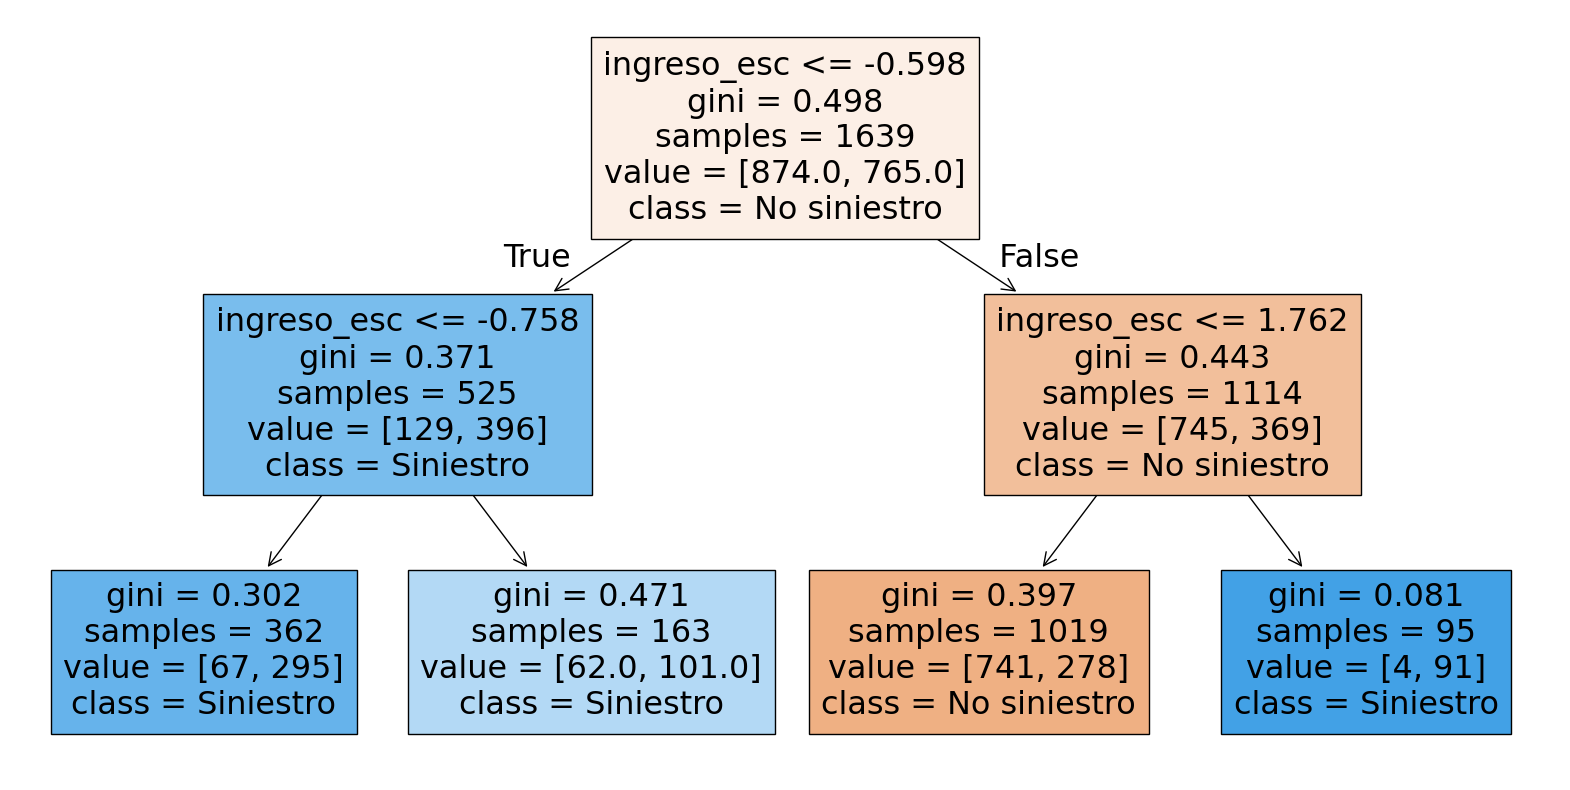

In [114]:
plt.figure(figsize=(20,10))
plot_tree(clf_tree, filled=True, feature_names=X_train.columns, class_names=['No siniestro', 'Siniestro'])
plt.show()

### SVM

In [33]:
clf_svm = SVC()
clf_svm.fit(X_train_scaled, y_train)

y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80       212
           1       0.83      0.65      0.73       198

    accuracy                           0.77       410
   macro avg       0.78      0.76      0.76       410
weighted avg       0.78      0.77      0.76       410



/home/juancho/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


## Fairness

Se realizan las pruebas sobre la variable del genero.

In [ ]:
from sklearn.metrics import confusion_matrix
def compute_rates(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    tp_r = tp/(tp+fn) if (tp + fn) > 0 else 0
    fp_r = fp/(fp+tn) if (fp + tn) > 0 else 0
    return tp_r, fp_r

### Regresion logistica
#### Equalized odds

In [67]:
mask0 = X_test['sexo'] == 0
tpr0, fpr0 = compute_rates(y_test[mask0], y_pred_lr[mask0])

mask1 = X_test['sexo'] == 1
tpr1, fpr1 = compute_rates(y_test[mask1], y_pred_lr[mask1])

print("Equalized Odds:")
print("  TPR(A=0) - TPR(A=1) =", tpr0-tpr1)
print("  FPR(A=0) - FPR(A=1) =", fpr0-fpr1)

Equalized Odds:
  TPR(A=0) - TPR(A=1) = 0.4096484898464076
  FPR(A=0) - FPR(A=1) = 0.20512820512820512


#### Equal opportunity

In [65]:
print("Equal Opportunity:")
print("  TPR (A=0) - TPR (A=1) =", tpr0-tpr1)

Equal Opportunity:
  TPR (A=0) - TPR (A=1) = 0.4096484898464076


#### Demographic parity

In [70]:
pos_rate0 = y_pred_lr[mask0].mean()
pos_rate1 = y_pred_lr[mask1].mean()

print("Demographic Parity:")
print("  P(Y_pred=1 | A=0) - P(Y_pred=1 | A=1) =", pos_rate0-pos_rate1)

Demographic Parity:
  P(Y_pred=1 | A=0) - P(Y_pred=1 | A=1) = 0.33673053403995107


#### Fairness through awareness

In [58]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(X_test)
threshold = 0.1
similar_pairs = (dists < threshold) & (dists > 0)
similarity_violation = np.mean(np.abs(y_pred_lr[:, np.newaxis] - y_pred_lr[np.newaxis, :])[similar_pairs])

print("Fairness through Awareness: Promedio de diferencia en similares =", similarity_violation)

Fairness through Awareness: Promedio de diferencia en similares = 0.0


Mientras que la prueba de fairness through awareness da un buen resultado (no parece haber discriminaciones entre datos similares), el resto de las pruebas muestran resultados muy diferentes, lo que parece indicar que el modelo si discrimina basado en el sexo.

### Arbol de decision
#### Equalized odds

In [71]:
mask0 = X_test['sexo'] == 0
tpr0, fpr0 = compute_rates(y_test[mask0], y_pred_tree[mask0])

mask1 = X_test['sexo'] == 1
tpr1, fpr1 = compute_rates(y_test[mask1], y_pred_tree[mask1])

print("Equalized Odds:")
print("  TPR(A=0) - TPR(A=1) =", tpr0-tpr1)
print("  FPR(A=0) - FPR(A=1) =", fpr0-fpr1)

Equalized Odds:
  TPR(A=0) - TPR(A=1) = 0.20173178022884242
  FPR(A=0) - FPR(A=1) = 0.09242250287026404


#### Equal opportunity

In [72]:
print("Equal Opportunity:")
print("  TPR (A=0) - TPR (A=1) =", tpr0-tpr1)

Equal Opportunity:
  TPR (A=0) - TPR (A=1) = 0.20173178022884242


#### Demographic parity

In [73]:
pos_rate0 = y_pred_tree[mask0].mean()
pos_rate1 = y_pred_tree[mask1].mean()

print("Demographic Parity:")
print("  P(Y_pred=1 | A=0) - P(Y_pred=1 | A=1) =", pos_rate0-pos_rate1)

Demographic Parity:
  P(Y_pred=1 | A=0) - P(Y_pred=1 | A=1) = 0.21069039111771898


#### Fairness through awareness

In [74]:
dists = euclidean_distances(X_test)
threshold = 0.1
similar_pairs = (dists < threshold) & (dists > 0)
similarity_violation = np.mean(np.abs(y_pred_tree[:, np.newaxis] - y_pred_tree[np.newaxis, :])[similar_pairs])

print("Fairness through Awareness: Promedio de diferencia en similares =", similarity_violation)

Fairness through Awareness: Promedio de diferencia en similares = 0.25510204081632654


Aunque, en este caso, la prueba de fairness through awareness obtiene un peor resultado, en general las pruebas devuelven valores similares y menos extremos que en el primer caso.

Ahora se muestran los resultados de los modelos pero sin tomar en consideracion la variable del genero para realizar la prediccion.

In [115]:
X_train_s = X_train.drop(columns='sexo')
X_test_s = X_test.drop(columns='sexo')

X_train_scaled_s = scaler.fit_transform(X_train_s)
X_test_scaled_s = scaler.transform(X_test_s)

### Regresion logistica

In [88]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train_scaled_s, y_train)

y_pred_lr = clf_lr.predict(X_test_s)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64       212
           1       0.57      0.32      0.41       198

    accuracy                           0.55       410
   macro avg       0.56      0.55      0.52       410
weighted avg       0.56      0.55      0.53       410



/home/juancho/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [91]:
mask0 = X_test['sexo'] == 0
tpr0, fpr0 = compute_rates(y_test[mask0], y_pred_lr[mask0])

mask1 = X_test['sexo'] == 1
tpr1, fpr1 = compute_rates(y_test[mask1], y_pred_lr[mask1])

print("Equalized Odds:")
print("  TPR(A=0) - TPR(A=1) =", tpr0-tpr1)
print("  FPR(A=0) - FPR(A=1) =", fpr0-fpr1)

print("Equal Opportunity:")
print("  TPR (A=0) - TPR (A=1) =", tpr0-tpr1)

pos_rate0 = y_pred_lr[mask0].mean()
pos_rate1 = y_pred_lr[mask1].mean()

print("Demographic Parity:")
print("  P(Y_pred=1 | A=0) - P(Y_pred=1 | A=1) =", pos_rate0-pos_rate1)

from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(X_test_s)
threshold = 0.1
similar_pairs = (dists < threshold) & (dists > 0)
similarity_violation = np.mean(np.abs(y_pred_lr[:, np.newaxis] - y_pred_lr[np.newaxis, :])[similar_pairs])

print("Fairness through Awareness: Promedio de diferencia en similares =", similarity_violation)

Equalized Odds:
  TPR(A=0) - TPR(A=1) = 0.10854551077208535
  FPR(A=0) - FPR(A=1) = -0.033677765021048606
Equal Opportunity:
  TPR (A=0) - TPR (A=1) = 0.10854551077208535
Demographic Parity:
  P(Y_pred=1 | A=0) - P(Y_pred=1 | A=1) = 0.052828469341262785
Fairness through Awareness: Promedio de diferencia en similares = 0.03


### Arbol de decision
De igual manera, se mantuvo la profundidad maxima del arbol en 2.

In [119]:
clf_tree = DecisionTreeClassifier(max_depth=2)
clf_tree.fit(X_train_s, y_train)

y_pred_tree = clf_tree.predict(X_test_s)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79       212
           1       0.83      0.64      0.72       198

    accuracy                           0.76       410
   macro avg       0.77      0.76      0.76       410
weighted avg       0.77      0.76      0.76       410



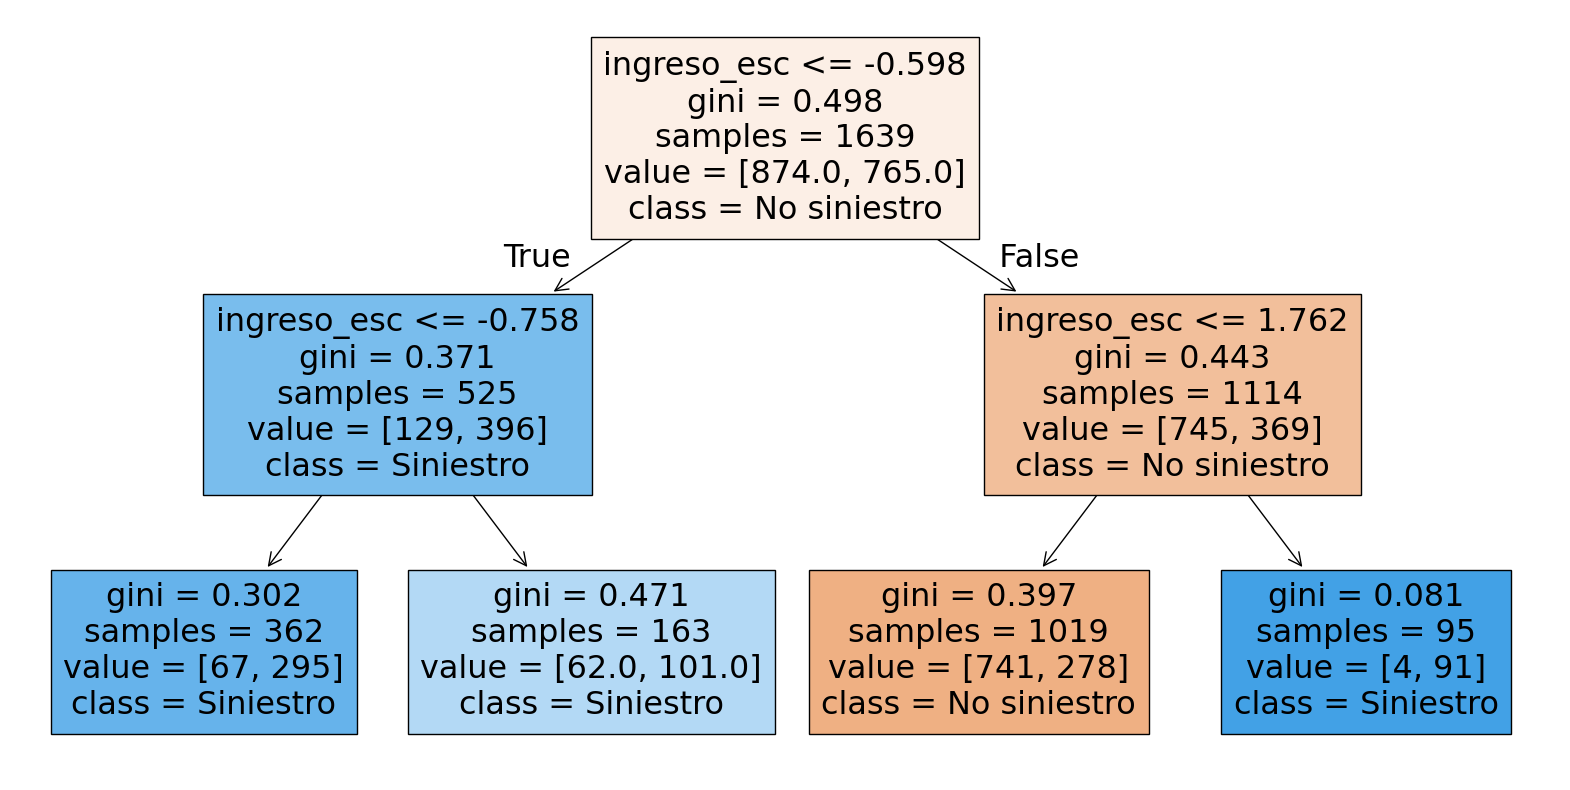

In [120]:
plt.figure(figsize=(20,10))
plot_tree(clf_tree, filled=True, feature_names=X_train_s.columns, class_names=['No siniestro', 'Siniestro'])
plt.show()

In [93]:
mask0 = X_test['sexo'] == 0
tpr0, fpr0 = compute_rates(y_test[mask0], y_pred_tree[mask0])

mask1 = X_test['sexo'] == 1
tpr1, fpr1 = compute_rates(y_test[mask1], y_pred_tree[mask1])

print("Equalized Odds:")
print("  TPR(A=0) - TPR(A=1) =", tpr0-tpr1)
print("  FPR(A=0) - FPR(A=1) =", fpr0-fpr1)

print("Equal Opportunity:")
print("  TPR (A=0) - TPR (A=1) =", tpr0-tpr1)

pos_rate0 = y_pred_tree[mask0].mean()
pos_rate1 = y_pred_tree[mask1].mean()

print("Demographic Parity:")
print("  P(Y_pred=1 | A=0) - P(Y_pred=1 | A=1) =", pos_rate0-pos_rate1)

from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(X_test_s)
threshold = 0.1
similar_pairs = (dists < threshold) & (dists > 0)
similarity_violation = np.mean(np.abs(y_pred_tree[:, np.newaxis] - y_pred_tree[np.newaxis, :])[similar_pairs])

print("Fairness through Awareness: Promedio de diferencia en similares =", similarity_violation)

Equalized Odds:
  TPR(A=0) - TPR(A=1) = 0.010926708586743605
  FPR(A=0) - FPR(A=1) = -0.0633371603520857
Equal Opportunity:
  TPR (A=0) - TPR (A=1) = 0.010926708586743605
Demographic Parity:
  P(Y_pred=1 | A=0) - P(Y_pred=1 | A=1) = 0.0318217788542241
Fairness through Awareness: Promedio de diferencia en similares = 0.305


Aunque en ambos casos la metrica F1 se reduce, tambien mejoran los resultados a las pruebas de fairness, mostrando que esta metrica no necesariamente esta relacionada a la precision del modelo.